We will use energy consumption time series to apply XGBoost algorithm after preprocessing and preparing the input data.This time series contains historical energy consumption of 5,567 randomly selected housholds in London, UK,for the time period of November 2002 to February 2018.

Before preparing the input sequences, let’s take a look at the columns and explore our data:

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
# Hourly Total Energy Consumption
df = pd.read_csv("PJME_hourly.csv", index_col=[0], parse_dates=[0])

df.head(24)
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


<Axes: title={'center': 'PJM'}, xlabel='Datetime'>

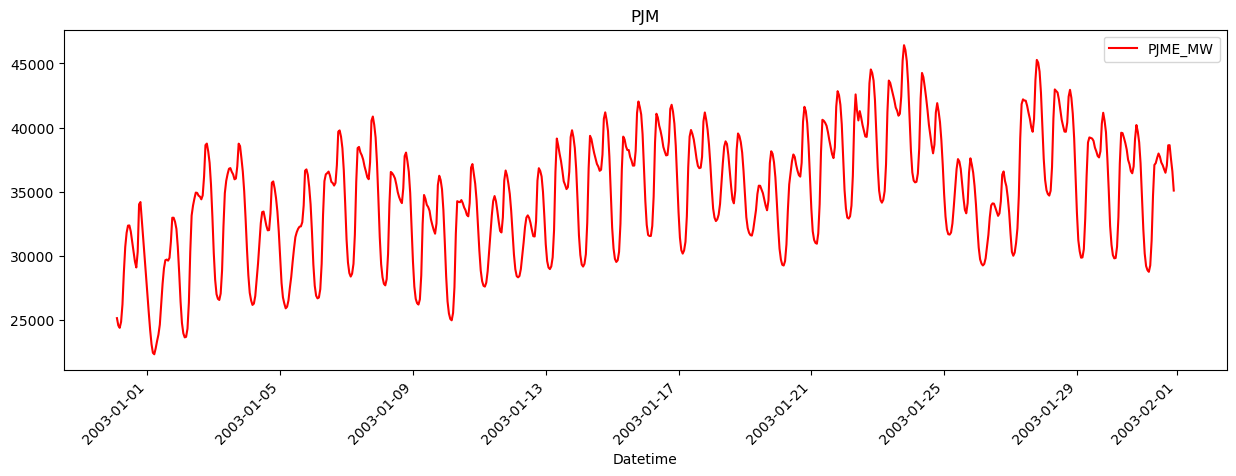

In [18]:
df_sample_OneWeek = df.query("Datetime > '2002-12-31 01:00:00' & Datetime < '2003-01-31 23:00:00 '")
df_sample_OneWeek.plot( figsize=(15,5), color='red', title='PJM', rot=45)

<Axes: xlabel='Datetime', ylabel='Energy consumption'>

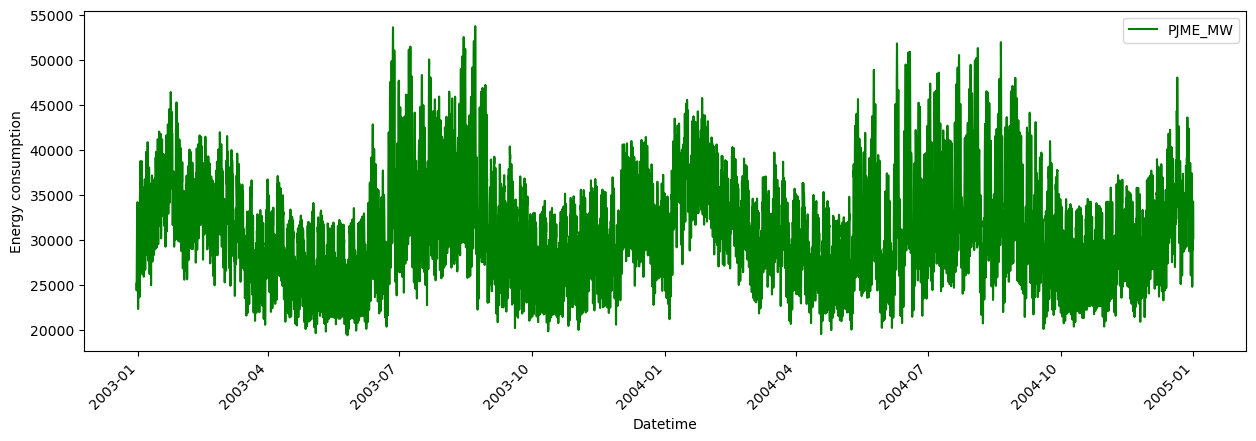

In [20]:
df_sample_2Years=df.query("Datetime > '2002-12-31 01:00:00' & Datetime < '2004-12-31 23:00:00 '")
df_sample_2Years.plot( ylabel= 'Energy consumption',figsize=(15,5), color='green', rot=45)

In [37]:
#Create Time Series Features

def create_X_y(df, label=None):
    df['Date'] = df.index
    df['hour'] = df['Date'].dt.hour
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    # drop 'datetime' column
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        
    return X, y
    
 


In [113]:
#Train/Test Split
#train_range = df.index <= '2017-01-01'
train_range = df.index >= '2006-01-01' 
train_set = df.loc[train_range].copy()
test_range =  df.index < '2006-01-01'
test_set = df.loc[test_range].copy()
print('length of training sequence:', len(train_set))
print('length of testing sequence:', len(test_set))

length of training sequence: 110311
length of testing sequence: 35055


In [114]:
X_train, y_train = create_X_y(train_set, label='PJME_MW')
X_test, y_test = create_X_y(test_set, label='PJME_MW')

C:\Users\la2022\AppData\Local\Temp\ipykernel_13072\870971758.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['Date'].dt.weekofyear
C:\Users\la2022\AppData\Local\Temp\ipykernel_13072\870971758.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['Date'].dt.weekofyear


In [118]:
from xgboost import XGBRegressor, plot_importance, plot_tree
model = XGBRegressor(n_estimators=3000, learning_rate=0.005)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

C:\Users\la2022\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=3000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

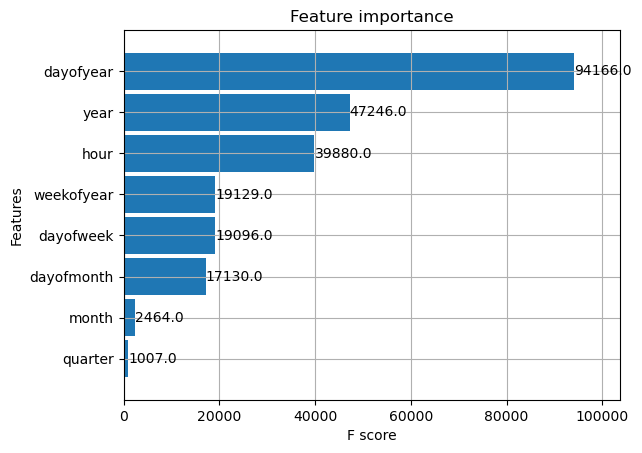

In [86]:
plot_importance(model, height=0.9)

In [119]:
predictions= model.predict(X_test)

In [105]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

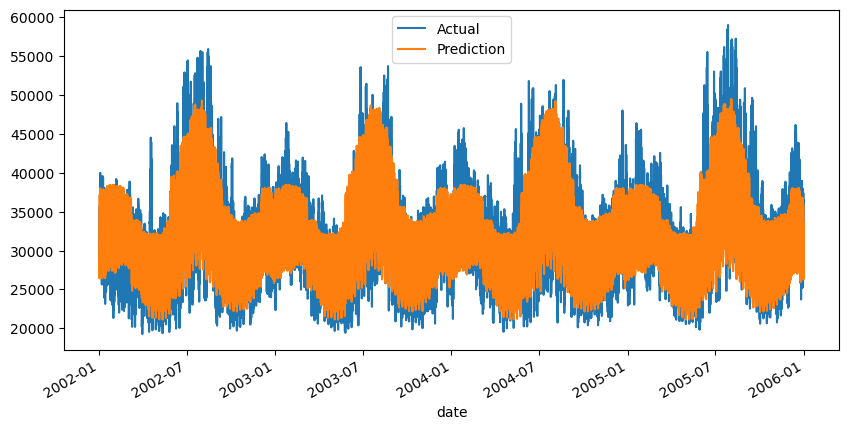

MAE: 2355.4664615202896
MSE: 10308156.479996415
MAPE: 0.07220287047428581


In [120]:
test_dates = test_set.index
plot_predictions(test_dates, y_test, predictions)
evaluate_model(y_test, predictions)